In [1]:
from netCDF4 import Dataset
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from time import time 
import scipy 
import h5py 

TRAIN_MONTHS = pd.date_range(start='1981-01-01', end='2014-12-01', freq='MS')
VAL_MONTHS = pd.date_range(start='2015-01-01', end='2018-12-01', freq='MS')
TEST_MONTHS = pd.date_range(start='2019-01-01', end='2024-06-01', freq='MS')
DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

def read_hdf5_file(data_path, data_name, load=True):
    with h5py.File(data_path, 'r') as f:
        return f[data_name][()]


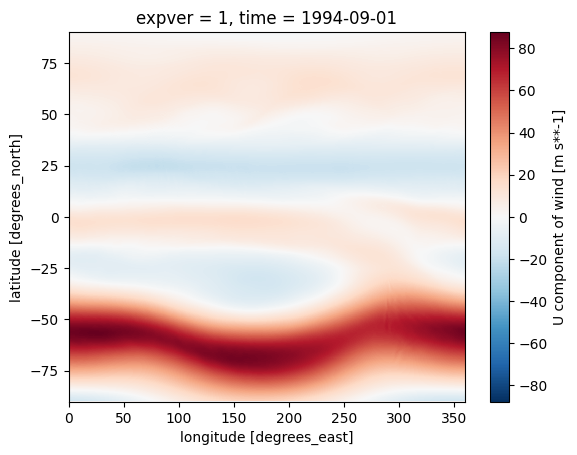

In [35]:
xr.open_dataset(f"{DATA_DIRECTORY}/ERA5/u_component_of_wind_10hPa.nc").u.isel(time=200, expver=0).plot()

In [14]:
siconc_da = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc").siconc
land_mask = ~xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/land_mask.nc").mask
siconc_anom_da = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/normalized_inputs/siconc_anom.nc").siconc
siconc_norm_da = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/normalized_inputs/siconc_norm.nc").siconc

siconc_anom_masked = siconc_anom_da.where(land_mask)


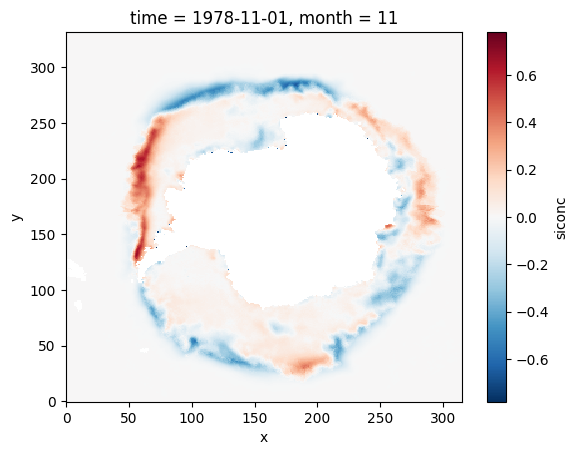

In [28]:
siconc_anom_masked.isel(time=0).plot()

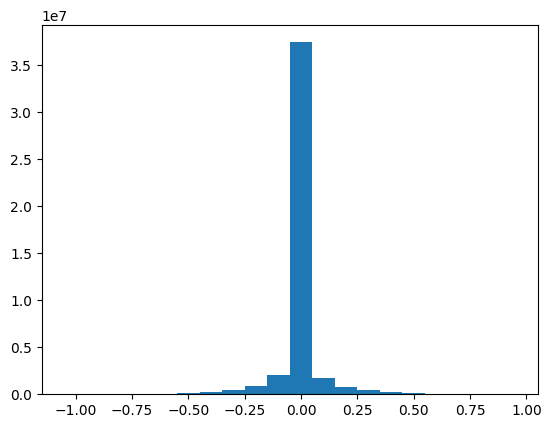

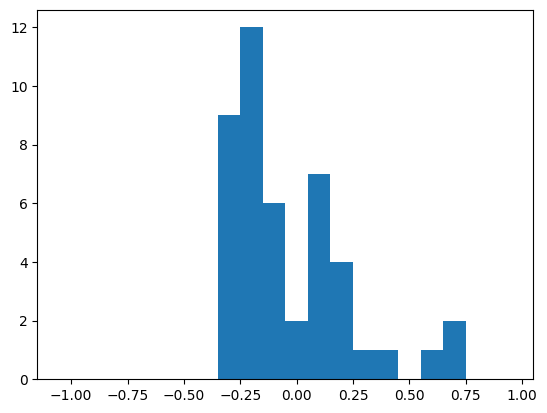

(array([0.000000e+00, 3.830000e+02, 1.943000e+03, 3.939000e+03,
        7.668000e+03, 1.490300e+04, 2.589600e+04, 4.243800e+04,
        7.367400e+04, 1.670650e+05, 3.145665e+06, 1.559450e+05,
        7.005400e+04, 3.795400e+04, 1.994100e+04, 1.129800e+04,
        5.500000e+03, 2.126000e+03, 2.820000e+02, 0.000000e+00]),
 array([-1.05, -0.95, -0.85, -0.75, -0.65, -0.55, -0.45, -0.35, -0.25,
        -0.15, -0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,
         0.75,  0.85,  0.95]),
 <BarContainer object of 20 artists>)

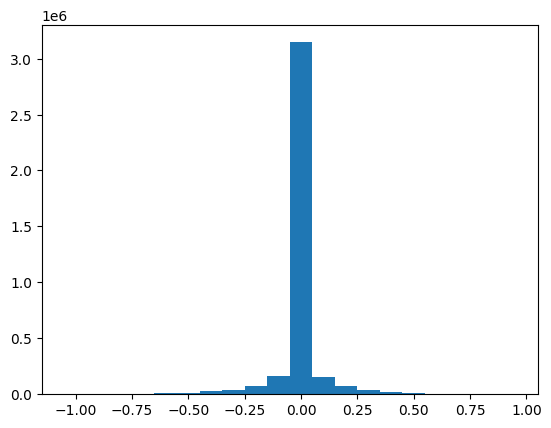

In [30]:
sicanom_jan = siconc_anom_masked.where(siconc_anom_masked.time.dt.month == 1, drop=True)
sicanom_jun = siconc_anom_masked.where(siconc_anom_masked.time.dt.month == 6, drop=True)

plt.hist(siconc_anom_masked.data.flatten(), bins=np.arange(-1.05, 1.05, 0.1))
plt.show()
plt.hist(sicanom_jan.isel(x=100, y=90).data.flatten(), bins=np.arange(-1.05, 1.05, 0.1))
plt.show()
plt.hist(sicanom_jun.data.flatten(), bins=np.arange(-1.05, 1.05, 0.1))

### Inputs/outputs

In [2]:
# params for problem definition 

# how many months into the future to predict 
max_month_lead_time = 6 

# input variable params  
input_config = {
    'siconc': {
        'plevel': None,
        'short_name': 'siconc',
        'include': True,
        'anom': False,
        'land_mask': True,
        'lag': 12
    },
    'siconc_linear_forecast': {
        'plevel': None,
        'short_name': 'siconc',
        'include': False,
        'anom': False,
        'land_mask': True,
        'lag': None
    },
    '10m_u_component_of_wind': {
        'plevel': None,
        'short_name': 'u10',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 1
    }, 
    '10m_v_component_of_wind': {
        'plevel': None,
        'short_name': 'v10',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 1
    }, 
    '2m_temperature': {
        'plevel': None,
        'short_name': 't2m',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    'mean_sea_level_pressure': {
        'plevel': None,
        'short_name': 'msl',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    'sea_surface_temperature': {
        'plevel': None,
        'short_name': 'sst',
        'include': False,
        'anom': True,
        'land_mask': True,
        'lag': 9
    }, 
    'surface_net_solar_radiation': {
        'plevel': None,
        'short_name': 'ssr',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    'surface_net_thermal_radiation': {
        'plevel': None,
        'short_name': 'str',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    'geopotential': {
        'plevel': '500',
        'short_name': 'z',
        'include': False,
        'anom': True,
        'land_mask': False,
        'lag': 3
    },
    'cosine_of_init_month': {
        'include': True,
        'land_mask': False
    },
    'sine_of_init_month': {
        'include': True,
        'land_mask': False
    }
}

# Note missing data for 1987 Dec and 1988 Jan. So remove those from the prediction months
first_range = pd.date_range('1981-01', pd.Timestamp('1987-12') - pd.DateOffset(months=max_month_lead_time+1), freq='MS')
second_range = pd.date_range(pd.Timestamp('1988-01') + pd.DateOffset(months=input_config['siconc']['lag']+1), '2024-01', freq='MS')

start_prediction_months = first_range.append(second_range)


In [2]:
inputs_simple = read_hdf5_file(f"{DATA_DIRECTORY}/sicpred/data_pairs_npy/inputs_simple.h5", "inputs_simple")

first_range = pd.date_range('1981-01', pd.Timestamp('1987-12') - pd.DateOffset(months=6+1), freq='MS')
second_range = pd.date_range(pd.Timestamp('1988-01') + pd.DateOffset(months=12+1), '2024-01', freq='MS')
start_prediction_months = first_range.append(second_range)

variable_list = ["siconca_lag12", "siconca_lag11", "siconca_lag10", "siconca_lag09",\
                "siconca_lag08", "siconca_lag07", "siconca_lag06", "siconca_lag05",\
                "siconca_lag04", "siconca_lag03", "siconca_lag02", "siconca_lag01",\
                "lin_forecast_lead1", "lin_forecast_lead2", "lin_forecast_lead3", \
                "lin_forecast_lead4", "lin_forecast_lead5", "lin_forecast_lead6", \
                "sst_lag3", "sst_lag2", "sst_lag1", "cosine_month", "sine_month"]

nsidc_sic = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc")
x = nsidc_sic.xgrid
y = nsidc_sic.ygrid

In [11]:
inputs_simple_ds = xr.Dataset(
    data_vars=dict(
        inputs=(["time", "variable", "y", "x"], inputs_simple),
    ),
    coords=dict(
        time=start_prediction_months, 
        variable=variable_list,
        xgrid=x,
        ygrid=y
    )
)

In [15]:
inputs_simple_ds

<xarray.Dataset> Size: 10GB
Dimensions:   (time: 497, variable: 23, y: 332, x: 316)
Coordinates:
    xgrid     (x) float32 1kB -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
    ygrid     (y) float32 1kB ...
  * time      (time) datetime64[ns] 4kB 1981-01-01 1981-02-01 ... 2024-01-01
  * variable  (variable) <U18 2kB 'siconca_lag12' ... 'sine_month'
Dimensions without coordinates: y, x
Data variables:
    inputs    (time, variable, y, x) float64 10GB 0.0 0.0 0.0 ... 0.5 0.5 0.5

### Look for large outliers in train/val dataset as a result of normalization

In [2]:
inputs_all_f = h5py.File(f"{DATA_DIRECTORY}/sicpred/data_pairs_npy/inputs_all.h5", 'r')
inputs_all = inputs_all_f['inputs_all']

In [3]:
input_config_all = {
    'siconc': {
        'plevel': None, 'short_name': 'siconc', 'include': True,
        'anom': False, 'land_mask': True, 'lag': 12
    },
    'siconc_linear_forecast': {
        'plevel': None, 'short_name': 'siconc', 'include': True,
        'anom': False, 'land_mask': True, 'lag': None
    },
    '10m_u_component_of_wind': {
        'plevel': None, 'short_name': 'u10', 'include': True,
        'anom': True, 'land_mask': False, 'lag': 1
    }, 
    '10m_v_component_of_wind': {
        'plevel': None, 'short_name': 'v10', 'include': True,
        'anom': True, 'land_mask': False, 'lag': 1
    }, 
    '2m_temperature': {
        'plevel': None, 'short_name': 't2m', 'include': True,
        'anom': True, 'land_mask': False, 'lag': 3
    }, 
    'mean_sea_level_pressure': {
        'plevel': None, 'short_name': 'msl', 'include': True,
        'anom': True, 'land_mask': False, 'lag': 3
    }, 
    'sea_surface_temperature': {
        'plevel': None, 'short_name': 'sst', 'include': True,
        'anom': True, 'land_mask': True, 'lag': 3
    }, 
    'surface_net_solar_radiation': {
        'plevel': None, 'short_name': 'ssr', 'include': True,
        'anom': True, 'land_mask': False, 'lag': 3
    }, 
    'surface_net_thermal_radiation': {
        'plevel': None, 'short_name': 'str', 'include': True,
        'anom': True, 'land_mask': False, 'lag': 3
    }, 
    'geopotential': {
        'plevel': '500', 'short_name': 'z', 'include': True,
        'anom': True, 'land_mask': False, 'lag': 3
    },
    'cosine_of_init_month': {
        'include': True, 'land_mask': False, 'short_name': 'cos'
    },
    'sine_of_init_month': {
        'include': True,'land_mask': False, 'short_name': 'sin'
    }
}

input_var_names = []

for input_var in input_config_all.keys():
    if input_config_all[input_var]["include"]:
        name = input_config_all[input_var]["short_name"]
        if input_var == "siconc_linear_forecast":
            for i in range(6):
                input_var_names.append(name + "_lin_" + str(i+1))
        else:
            if "lag" in input_config_all[input_var].keys():
                for i in range(input_config_all[input_var]["lag"]):
                    input_var_names.append(name + "_" + str(i+1))
            else:
                input_var_names.append(name)

# Calculate the max normalized value for each time 
max_norm = {}
for i,input_name in enumerate(input_var_names): 
    max_norm[input_name] = np.abs(np.max(inputs_all[:,i,:,:], axis=(1,2)))


In [14]:
inputs_all_anom_f = h5py.File(f"{DATA_DIRECTORY}/sicpred/data_pairs_npy/inputs_all_sicanom.h5", 'r')
inputs_all_anom = inputs_all_f['inputs_all']

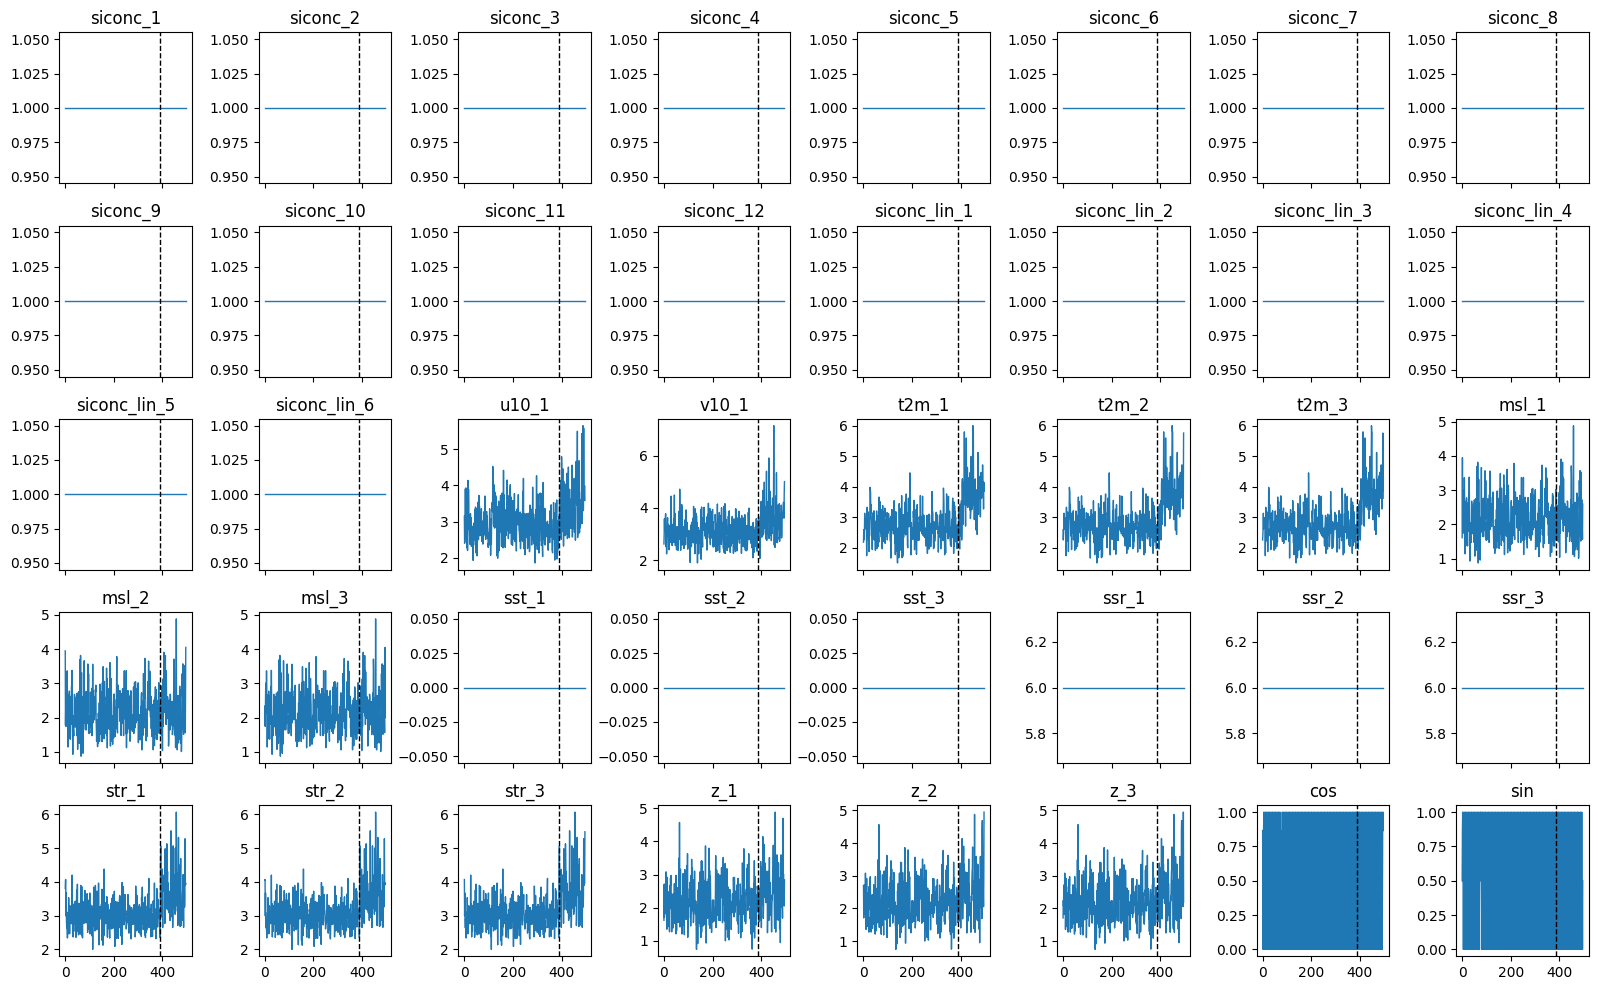

In [4]:
first_range = pd.date_range('1981-01', pd.Timestamp('1987-12') - pd.DateOffset(months=6+1), freq='MS')
second_range = pd.date_range(pd.Timestamp('1988-01') + pd.DateOffset(months=12+1), '2024-01', freq='MS')
start_prediction_months = first_range.append(second_range)


fig, axs = plt.subplots(nrows=5, ncols=8, figsize=(16, 10), sharex=True)

axs = axs.flatten()

for i,ax in enumerate(axs):
    input_var = input_var_names[i]
    val_index = start_prediction_months.get_loc(VAL_MONTHS[0])

    ax.plot(max_norm[input_var], linewidth=1)
    ax.axvline(val_index, linewidth=1, linestyle='dashed', color='k')
    ax.set_title(input_var)

fig.tight_layout()
#plt.savefig("../figures/known_issues/all_variables_max_vals.jpg", dpi=300, bbox_inches="tight")

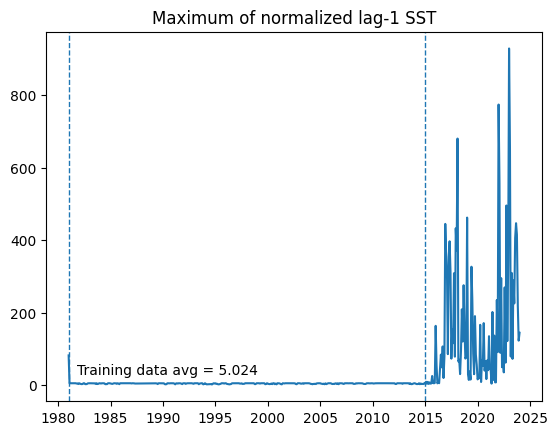

In [83]:
# Calculate the max normalized SST value
max_normalized_sst = np.abs(inputs_simple_ds.inputs.sel(variable='sst_lag1')).max(dim=("x","y"))

plt.plot(max_normalized_sst.time, max_normalized_sst)
plt.title("Maximum of normalized lag-1 SST")
plt.axvline(x=VAL_MONTHS[0], linewidth=1, linestyle='dashed')
plt.axvline(x=TRAIN_MONTHS[0], linewidth=1, linestyle='dashed')

train_months_with_data = start_prediction_months.intersection(TRAIN_MONTHS)
avg_max_normalized_sst_train = max_normalized_sst.sel(time=train_months_with_data[1:]).mean().data
plt.text(TRAIN_MONTHS[10], 30, f"Training data avg = {avg_max_normalized_sst_train:.3f}")
plt.savefig("../figures/known_issues/super_out_of_sample_SSTs.jpg", dpi=300, bbox_inches="tight")


### Notes from previous experimentation

7/17 SST below sea ice has very very small standard deviations ($\sigma \sim \mathcal{O}(0.0001)$) since it is in equilibrium with the sea ice. So $(x - \mu)/\sigma$ is a small number over a small number. Normalized values don't really make too much physical sense.

One option is to set a threshold minimum bound for $x - \mu$ for SST only, and set the normalized value to 0 (since we expect SST under sea ice to be $\approx T_f$)

Edit:
7/18: set threshold value for $\sigma$. See util.py